## 1. System Setup & Reproducibility

To ensure our results are reliable and reproducible, we must configure our environment carefully.

### Key Configuration Steps:
1.  **Imports:** Loading necessary libraries for Deep Learning (PyTorch), Image Processing (PIL), and Visualization (Matplotlib).
2.  **Random Seeds:** We lock the "Random Seed" to `42`. This ensures that random operations (like splitting data or initializing weights) happen the exact same way every time we run this notebook.
3.  **Hardware Check:** We automatically detect if a GPU (CUDA) is available to accelerate training.

In [50]:
# --- 1. SYSTEM SETUP ---
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image

# --- REPRODUCIBILITY SETUP ---
SEED = 42  # Pick one seed and stick to it

# Python & Numpy seeds
random.seed(SEED)
np.random.seed(SEED)

# PyTorch seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) # For multi-GPU

# CUDNN Deterministic mode (slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"System Ready. Training on: {DEVICE}")

System Ready. Training on: cuda


## 2. Data Exploration (EDA)

Before building the model, we perform a visual "Sanity Check" on the dataset. This step confirms that:
1.  The directory structure (`train`, `val`, `test`) is correct.
2.  The images are readable and labeled correctly.
3.  We can visually distinguish between "Normal" and "Pneumonia" cases.

**Visualization Logic:**
* We iterate through the three data subsets.
* For each subset, we plot one **Normal** X-ray (Top Row) and one **Pneumonia** X-ray (Bottom Row).
* We normalize the figure layout to make the comparison clear.

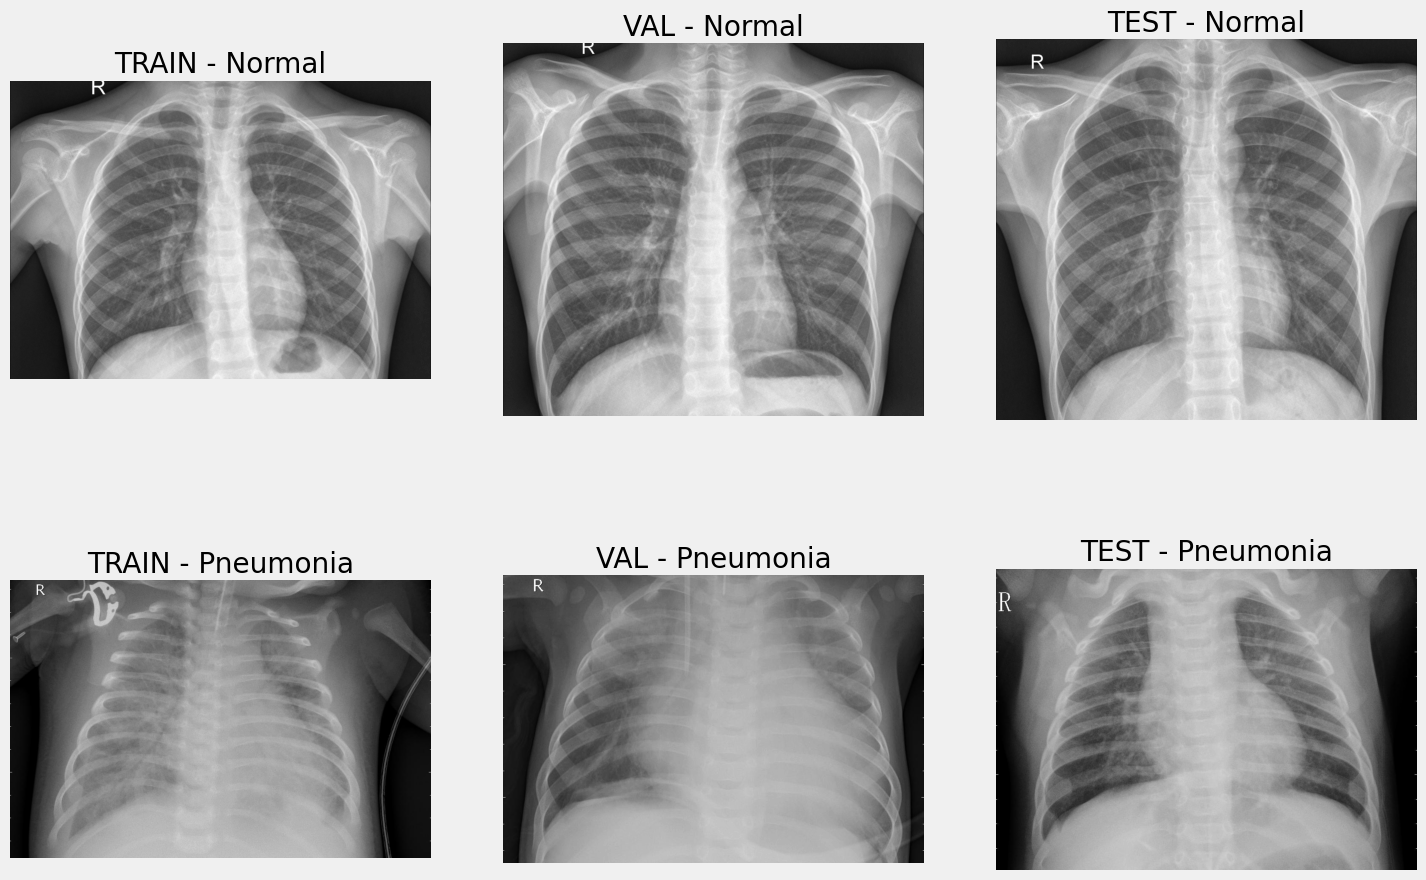

In [51]:
# --- 2. DATA EXPLORATION ---
# Define the dataset path
path = 'chest_xray'  # Make sure this folder exists in your directory

# Setup the figure
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
plt.tight_layout()

for i, subset in enumerate(['train', 'val', 'test']):
    set_path = os.path.join(path, subset)
    normal_folder = os.path.join(set_path, 'NORMAL')
    pneumonia_folder = os.path.join(set_path, 'PNEUMONIA')

    # Safety Check: Skip if folders don't exist
    if not os.path.exists(normal_folder) or not os.path.exists(pneumonia_folder):
        print(f"⚠️ Warning: {subset} folders not found. Skipping plot.")
        continue

    # 1. Plot Normal (Top Row: Indices 0, 1, 2)
    normal_images = os.listdir(normal_folder)
    if normal_images:
        img_path = os.path.join(normal_folder, normal_images[0])
        ax[i].imshow(plt.imread(img_path), cmap='gray')
        ax[i].set_title(f'{subset.upper()} - Normal')
        ax[i].axis('off')

    # 2. Plot Pneumonia (Bottom Row: Indices 3, 4, 5)
    pneumonia_images = os.listdir(pneumonia_folder)
    if pneumonia_images:
        img_path = os.path.join(pneumonia_folder, pneumonia_images[0])
        ax[i+3].imshow(plt.imread(img_path), cmap='gray')
        ax[i+3].set_title(f'{subset.upper()} - Pneumonia')
        ax[i+3].axis('off')

plt.show()

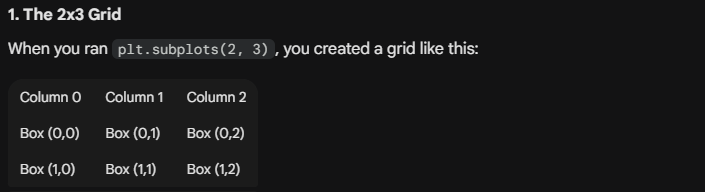
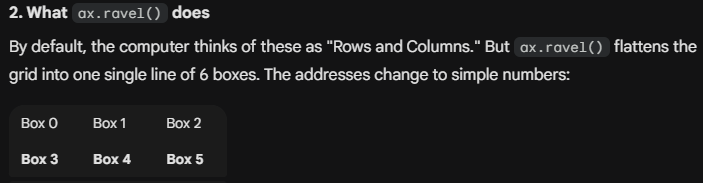

## 3. Data Processing & Augmentation Pipeline

This block handles the **ETL (Extract, Transform, Load)** process. We prepare the raw images for the DenseNet121 model.

### A. Industry Standard Normalization
We use specific mean and standard deviation values:
* `mean = [0.485, 0.456, 0.406]`
* `std = [0.229, 0.224, 0.225]`
**Why?** Our model was pre-trained on the ImageNet dataset. These numbers represent the average color distribution of ImageNet. By normalizing our X-rays to match these statistics, we ensure the pre-trained weights function correctly.

### B. Medical-Safe Data Augmentation
We apply random transformations to the **Training Set** to prevent overfitting.
* **Included:** `RandomAffine` (Rotation +/- 5°, Zoom +/- 5%, Shift). This simulates patients standing slightly off-center or the X-ray machine being at different distances.
* **Excluded:** `RandomHorizontalFlip`.
    * **CRITICAL:** In standard computer vision (e.g., classifying cats), flipping an image is fine. In medical imaging, flipping is **dangerous**. It would create a condition called *Dextrocardia* (heart on the right side), teaching the model false anatomy. We strictly avoid this.

### C. DataLoader Optimization
* `num_workers=2`: Uses parallel processing to load images while the GPU trains.
* `pin_memory=True`: Accelerates the transfer of data from CPU RAM to GPU VRAM.

In [52]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def process_data(img_dims, batch_size, path):
    # INDUSTRY STANDARD: ImageNet Normalization Statistics
    # These numbers are fixed constants used by almost all pre-trained models.
    NORM_MEAN = [0.485, 0.456, 0.406]
    NORM_STD = [0.229, 0.224, 0.225]

    # 1. Define Transformations
    train_transforms = transforms.Compose([
        transforms.Resize((img_dims, img_dims)),        
        transforms.RandomAffine(
            degrees=5,             # Rotate slightly (+/- 5 degrees)
            translate=(0.02, 0.02),# Shift image slightly
            scale=(0.95, 1.05)     # Zoom in/out slightly
        ),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD) # <--- CRITICAL ADDITION
    ])

    # Validation/Test: Resize -> Tensor -> Normalize
    test_val_transforms = transforms.Compose([
        transforms.Resize((img_dims, img_dims)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD) # Must match training stats
    ])

    # 2. Define Datasets
    train_dataset = datasets.ImageFolder(
        root=os.path.join(path, 'train'), 
        transform=train_transforms
    )
    
    val_dataset = datasets.ImageFolder(
        root=os.path.join(path, 'val'), 
        transform=test_val_transforms
    )
    
    test_dataset = datasets.ImageFolder(
        root=os.path.join(path, 'test'), 
        transform=test_val_transforms
    )

    # 3. Define Loaders
    # num_workers=2 allows the CPU to prepare the next batch while GPU trains (Speed up)
    # pin_memory=True speeds up transfer from RAM to GPU
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True) # Shuffle=False
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, val_loader

# Parameters
img_dims = 224 # Changed to industry standard
batch_size = 32
path = 'chest_xray'

# Run
train_loader, test_loader, val_loader = process_data(img_dims, batch_size, path)
print(f"Data Ready. Batches: {len(train_loader)}")

Data Ready. Batches: 129


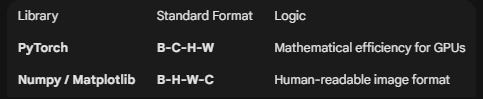

## 4. Model Architecture: Custom DenseNet121

We employ **Transfer Learning** using the DenseNet121 architecture.

### A. The Backbone (DenseNet121)
* **Source:** We load weights pre-trained on **ImageNet** (`weights='DEFAULT'`). This gives the model a foundational understanding of edges, textures, and shapes.
* **Strategy:** We use **DenseNet** (Densely Connected Convolutional Networks) because it uses *feature concatenation* rather than addition (like ResNet). This preserves low-level texture features (critical for identifying lung opacities) as they pass deeper into the network. 
* **Freezing:** We set `requires_grad = False` for the feature layers. This "locks" the pre-trained knowledge, preventing the new random classifier from destroying the delicate texture-detection weights during the first few epochs.

### B. The Custom Adapter (The "Head")
We replace the original 1000-class classifier with a custom binary classifier designed for medical diagnosis:
1.  **Linear (1024 $\to$ 512):** Compresses the high-dimensional feature map.
2.  **LeakyReLU:** We use Leaky Rectified Linear Unit to prevent the "Dying ReLU" problem, ensuring gradients can still flow even if neurons output negative values.
3.  **Dropout (20%):** A regularization technique that randomly zeroes out neurons during training. This prevents the model from over-relying on specific pixels (overfitting) and encourages it to look at the whole lung.
4.  **Sigmoid Output:** The final activation function squashes the output between 0 and 1, providing a direct **Probability of Pneumonia**.

In [53]:
import torch
import torch.nn as nn
from torchvision import models

class ChestDenseNet(nn.Module):
    def __init__(self):
        super(ChestDenseNet, self).__init__()
        
        # 1. LOAD DenseNet121
        self.model = models.densenet121(weights='DEFAULT')      # weights='DEFAULT' downloads the pre-trained weights

        # 2. FREEZE THE BRAIN
        # We lock the feature extractor to keep the pre-trained "texture detection" skills
        for param in self.model.features.parameters():
            param.requires_grad = False
            
        # 3. SWAP THE HEAD
        # DenseNet121 has 1024 features going into the classifier
        num_features = self.model.classifier.in_features 
        
        # We replace the classifier with a custom one
        self.model.classifier = nn.Sequential(
            nn.Linear(num_features, 512),   # Compresses the information.
            nn.LeakyReLU(),                 # Non-linearity activation function
            nn.Dropout(0.2),                # Important to prevent overfitting
            nn.Linear(512, 1)               # Final Decision (Pneumonia Probability)
        )
        
    def forward(self, x):
        x = self.model(x)
        return torch.sigmoid(x)     # activation function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChestDenseNet().to(device)

print(f"Model: DenseNet121")

Model: DenseNet121


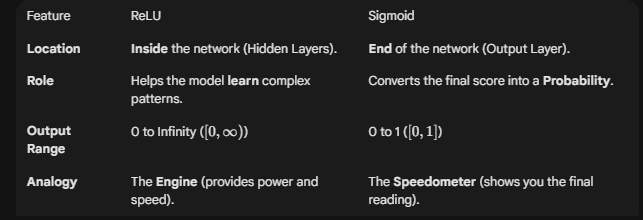

## 5. Training Loop & Optimization

This block executes the core learning process.

### A. Optimization Strategy
* **Optimizer: Adam (`lr=0.001`)**
    * We use **Adam** (Adaptive Moment Estimation) instead of basic SGD. Adam adjusts the learning rate for each parameter individually, acting like a "smart" optimizer that speeds up convergence in deep networks.
* **Loss Function: BCELoss**
    * Since we are doing **Binary Classification** (0 vs 1) and our model ends with a Sigmoid activation, we use **Binary Cross Entropy Loss**. This penalizes the model heavily for confident but wrong predictions. [Image of binary cross entropy loss graph]

### B. Dynamic Learning Rate (Scheduler)
* **ReduceLROnPlateau:**
    * **The Problem:** As the model gets smarter, a high learning rate causes it to "overshoot" the optimal solution.
    * **The Solution:** If the Validation Loss stops improving for 2 epochs (`patience=2`), we automatically multiply the learning rate by 0.3 (`factor=0.3`). This allows the model to fine-tune its weights with smaller, more precise steps.

### C. Checkpointing (Early Stopping logic)
* We track the **Validation Loss** at every epoch.
* If the current model performs better than the previous best, we save its weights immediately (`best_model_wts`).
* This ensures that even if the model starts overfitting at Epoch 12, we still possess the "perfect" version from Epoch 8.

In [54]:
import torch.optim as optim
import time
import copy

# 1. Setup Optimizer, Loss, and Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.BCELoss() 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=2 # Reduce LR by 70% if no improvement in 2 epochs
) 

# Parameters
epochs = 12
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

print("Starting Training...")
# 2. Training Loop
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    start_time = time.time()
    
    # --- TRAINING PHASE ---
    model.train() # train the model
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:     # inputs = chest images (N, 3, 224, 224), labels: NORMAL or PNEUMONIA(N)

        inputs = inputs.to(device)      
        labels = labels.to(device).float().unsqueeze(1) # Match shape (N, 1)

        optimizer.zero_grad()                           # Zero Gradients
        outputs = model(inputs)                         # Forward Pass
        loss = loss_function(outputs, labels)           # Compute Loss
        loss.backward()                                 # Backward Pass 
        optimizer.step()                                # Update Weights

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float() # Threshold at 0.5
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    # --- VALIDATION PHASE ---
    model.eval() # evaluate the model
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():       # Don't calculate gradients for validation (saves RAM)
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    
    # --- CALLBACKS ---
    # 1. Update History
    history['train_loss'].append(epoch_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(epoch_acc.item())
    history['val_acc'].append(val_acc.item())
    
    # 2. Step the Scheduler (ReduceLROnPlateau)
    scheduler.step(val_loss)
    
    # 3. ModelCheckpoint (Save best model)
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_chest_xray_model.pth')
        save_msg = "--> Saved Best Model"
    else:
        save_msg = ""

    # Print stats
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} {save_msg}")

print("Training Complete.")

Starting Training...
Epoch 1/12 | Train Loss: 0.3108 Acc: 0.8661 | Val Loss: 0.1930 Acc: 0.9293 --> Saved Best Model
Epoch 2/12 | Train Loss: 0.2220 Acc: 0.9095 | Val Loss: 0.1781 Acc: 0.9373 --> Saved Best Model
Epoch 3/12 | Train Loss: 0.2019 Acc: 0.9180 | Val Loss: 0.1793 Acc: 0.9327 
Epoch 4/12 | Train Loss: 0.1663 Acc: 0.9363 | Val Loss: 0.1712 Acc: 0.9316 --> Saved Best Model
Epoch 5/12 | Train Loss: 0.1919 Acc: 0.9251 | Val Loss: 0.1687 Acc: 0.9384 --> Saved Best Model
Epoch 6/12 | Train Loss: 0.1621 Acc: 0.9378 | Val Loss: 0.1681 Acc: 0.9327 --> Saved Best Model
Epoch 7/12 | Train Loss: 0.1618 Acc: 0.9380 | Val Loss: 0.1628 Acc: 0.9453 --> Saved Best Model
Epoch 8/12 | Train Loss: 0.1541 Acc: 0.9412 | Val Loss: 0.1742 Acc: 0.9304 
Epoch 9/12 | Train Loss: 0.1593 Acc: 0.9405 | Val Loss: 0.1820 Acc: 0.9293 
Epoch 10/12 | Train Loss: 0.1540 Acc: 0.9427 | Val Loss: 0.2150 Acc: 0.9031 
Epoch 11/12 | Train Loss: 0.1378 Acc: 0.9461 | Val Loss: 0.1557 Acc: 0.9453 --> Saved Best Model
E

## 6. Final Evaluation (The "Hold-Out" Test)

Now that training is complete, we must evaluate the model's performance on the **Test Set**.

### A. The Evaluation Function (`evaluate_loader`)
We create a helper function to avoid repeating code (DRY Principle).
* **`model.eval()`:** Ensures the model is in "Production Mode" (locking Dropout and Batch Normalization layers).
* **`torch.no_grad()`:** Disables the Autograd engine to save memory and computation power.

### B. Train vs. Test Comparison
We calculate metrics for both datasets to check for **Overfitting**:
* **Good Scenario:** Train Accuracy (e.g., 95%) is similar to Test Accuracy (e.g., 94%). This means the model **generalizes** well.
* **Overfitting Scenario:** Train Accuracy is high (99%) but Test Accuracy is low (75%). This means the model just memorized the training images and failed to learn the actual medical patterns.

In [55]:
def evaluate_loader(model, loader, loss_function, name="Dataset"):
    model.eval()        # 1. Lock the model (freeze Dropout/BatchNorm)
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    print(f"Evaluating on {name}...")
    
    with torch.no_grad(): # 2. Disable gradient calculation
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1) # Match shape (N, 1)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            # Accumulate stats
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    # 3. Calculate Averages
    avg_loss = running_loss / total_samples
    avg_acc = (running_corrects.double() / total_samples).item()
    
    return avg_loss, avg_acc

# --- EVALUATION PHASE ---

# Calculate scores
train_loss, train_acc = evaluate_loader(model, train_loader, loss_function, "Train Set")
test_loss, test_acc = evaluate_loader(model, test_loader, loss_function, "Test Set")

# Print resultS
print("-" * 30)
print(f"Train Loss:  {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")
print("-" * 30)
print(f"Test Loss:   {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print("-" * 30)

Evaluating on Train Set...
Evaluating on Test Set...
------------------------------
Train Loss:  0.1203
Train Accuracy: 0.9571
------------------------------
Test Loss:   0.1409
Test Accuracy:  0.9443
------------------------------


## 7. Performance Visualization (Learning Curves)

Visualizing the training process is crucial to diagnose the model's behavior. We plot **Loss** and **Accuracy** over the 12 epochs.

### How to Read These Graphs:
1.  **Loss Graph (Left):**
    * **Goal:** Both Red (Train) and Green (Validation) lines should go **down**.
    * **Overfitting:** If the Red line keeps going down but the Green line starts going **up**, the model is memorizing the data.
    * **The Blue Dot:** This marks the **Best Epoch** (lowest Validation Loss). This is the specific version of the model we saved to `best_model_wts`.

2.  **Accuracy Graph (Right):**
    * **Goal:** Both lines should go **up**.
    * **Convergence:** The lines should eventually flatten out (plateau), indicating the model has learned as much as it can.

**Note:** We focus more on **Validation Loss** than Accuracy when choosing the best model, as it is a more sensitive metric for probability confidence.

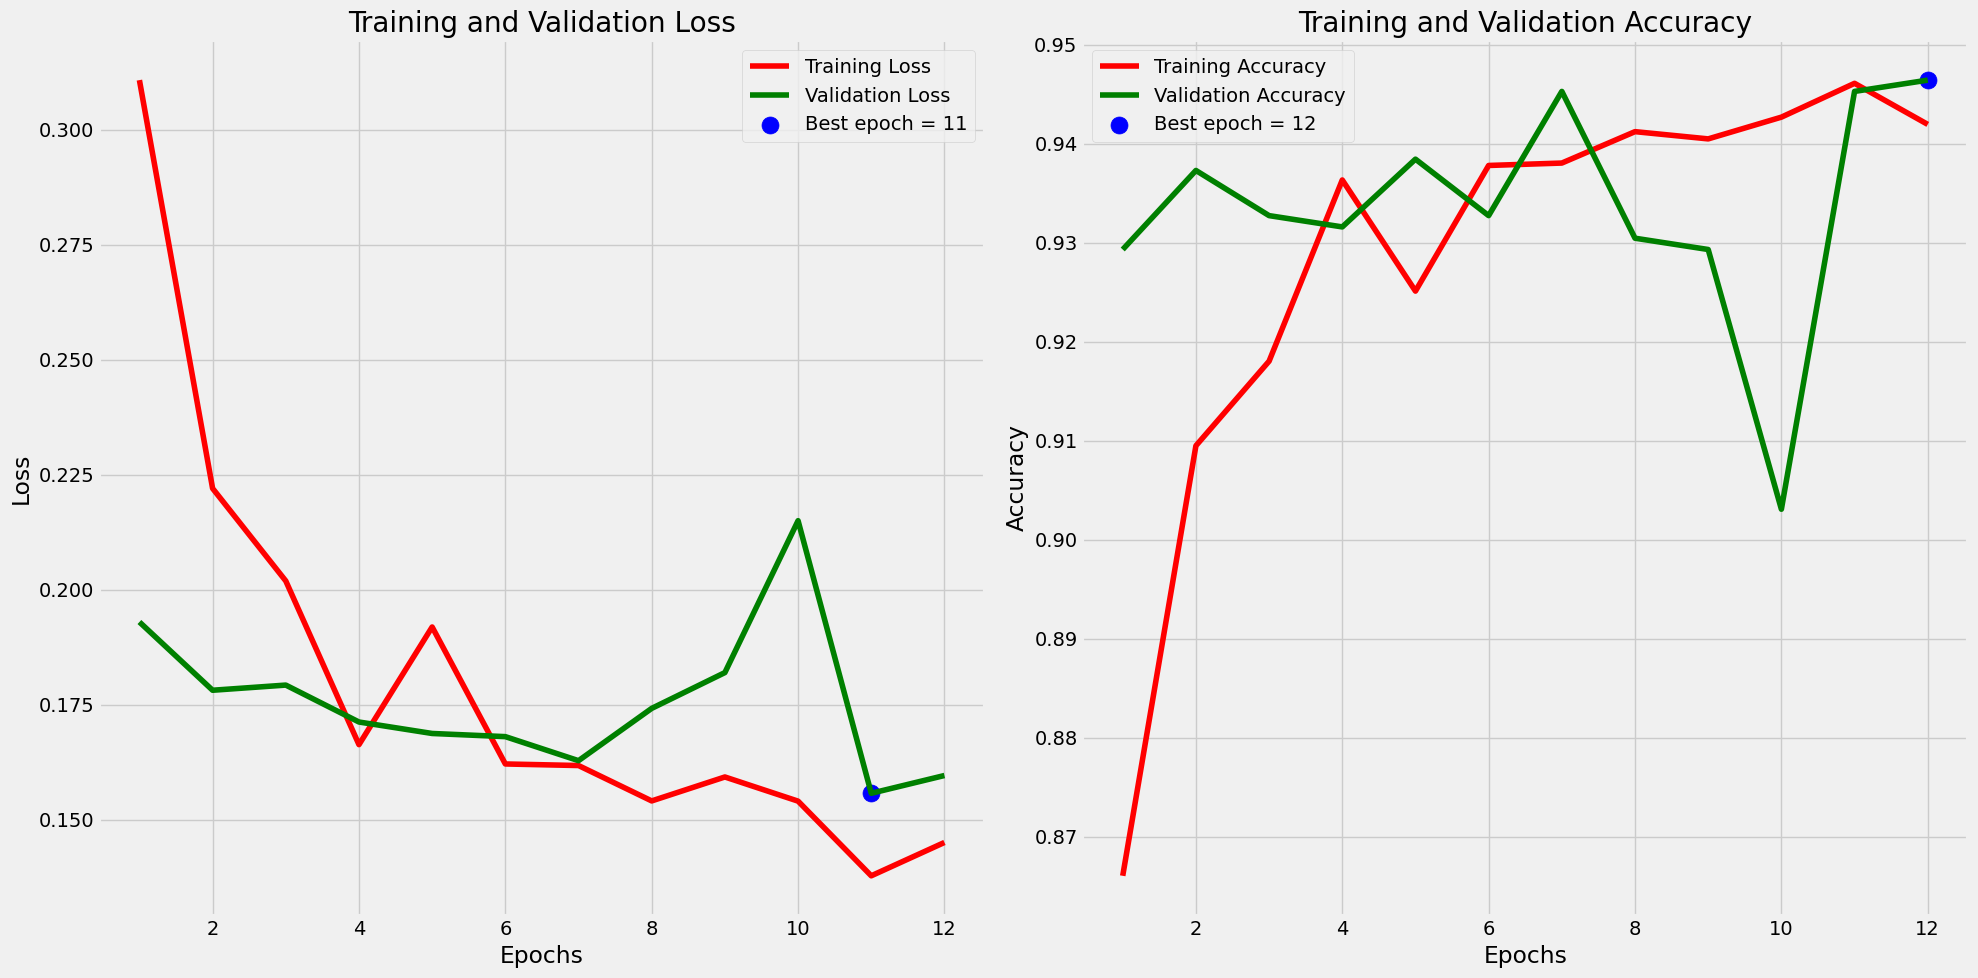

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Extract Data from our Manual History Dictionary
tr_acc = history['train_acc']
tr_loss = history['train_loss']
val_acc = history['val_acc']
val_loss = history['val_loss']

# 2. Identify Best Epochs (Standard Numpy)
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# List of epochs (1 to 12)
Epochs = [i + 1 for i in range(len(tr_acc))]

# Labels for the plot
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# 3. Plotting (Standard Matplotlib)
plt.figure(figsize=(20, 10))
plt.style.use('fivethirtyeight')

# Plot A: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot B: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 8. Diagnostic Metrics (Confusion Matrix & F1-Score)

In medical diagnostics, **Accuracy is not enough**. We need to understand *how* the model fails.

### A. The Confusion Matrix
This visualization breaks down the predictions into four categories:
* **True Positives (TP):** Sick patients correctly identified as Sick. (Good)
* **True Negatives (TN):** Healthy patients correctly identified as Healthy. (Good)
* **False Negatives (FN):** Sick patients incorrectly marked as Healthy. **(CRITICAL RISK)** - This means we sent a sick patient home without treatment.
* **False Positives (FP):** Healthy patients incorrectly marked as Sick. **(Cost Risk)** - This causes unnecessary stress and expensive follow-up tests.

### B. The Classification Report
We focus on two key metrics for the "Pneumonia" class:
1.  **Recall (Sensitivity):** Out of all the people who *actually* have Pneumonia, what percentage did we catch? (We want this near 100% to avoid missing cases).
2.  **Precision:** Out of all the people we *predicted* have Pneumonia, how many actually did?

**Goal:** We aim for a high **F1-Score** (the balance between Precision and Recall).

Generating predictions...
Test Accuracy: 94.43%


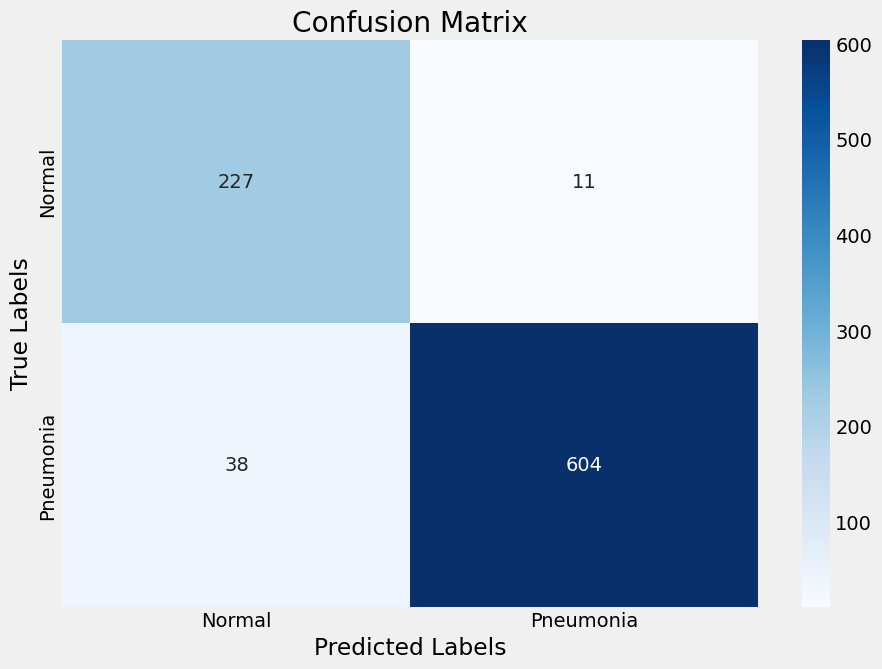


Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.95      0.90       238
   Pneumonia       0.98      0.94      0.96       642

    accuracy                           0.94       880
   macro avg       0.92      0.95      0.93       880
weighted avg       0.95      0.94      0.95       880



In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generate Predictions 
y_pred_list = []
y_true_list = []

model.eval()  # Safety Mode: Freeze layers

print("Generating predictions...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Move predictions to CPU and convert to NumPy
        # We don't round yet; we just want the raw probabilities or 0/1 logic
        preds = (outputs > 0.5).float().cpu().numpy() 
        
        y_pred_list.extend(preds)
        y_true_list.extend(labels.cpu().numpy())

# Convert lists to flat numpy arrays for Scikit-learn
rounded_preds = np.array(y_pred_list).flatten()
test_labels = np.array(y_true_list).flatten()

# 2. Plotting
# Calculate Accuracy
acc = accuracy_score(test_labels, rounded_preds)
print(f'Test Accuracy: {acc * 100:.2f}%')

# Confusion Matrix
cm = confusion_matrix(test_labels, rounded_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, rounded_preds, target_names=['Normal', 'Pneumonia']))